# Notebook 1: Neural ODE 2D Classification

Este notebook implementa e treina Neural ODEs para classificação em dados 2D.

## Objetivos:
1. Implementar VectorField e NeuralODE com classificação
2. Treinar em dataset 2D sintético (moons, circles, spirals)
3. Visualizar trajetórias a partir de dados do dataset (x(0) → x(1))
4. Visualizar transformações a partir de z ~ N(0,I) (z(0) → x(1))
5. Visualizar vector fields
6. Analisar NFEs e comparar solvers


In [1]:
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('..')
import torch
import torch.optim as optim
from src.models.neural_ode import NeuralODE
from src.models.vector_field import VectorField
from src.utils.datasets import Synthetic2D, get_dataloader
from src.utils.training import train_neural_ode, count_nfe
from src.utils.visualization import Synthetic2DViz

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Directories for saving figures and checkpoints
FIGURES_DIR = '../results/figures'
CHECKPOINTS_DIR = '../results/checkpoints'
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

# Dataset and model names for file naming
DATASET_NAME = 'moons'
MODEL_NAME = 'neuralode'

Using device: cuda


## 1. Carregar Dataset


Figure saved to: ../results/figures/01_moons_neuralode.png


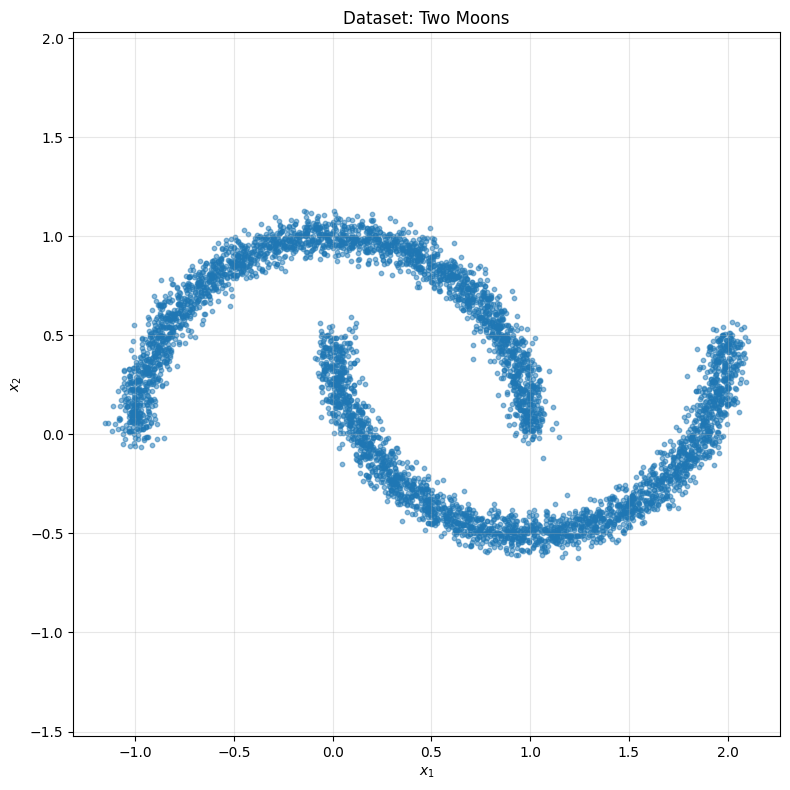

Dataset size: 5000


In [2]:
# Criar dataset (moons, circles, ou spirals - todos têm 2 classes)
dataset = Synthetic2D(n_samples=5000, noise=0.05, dataset_type=DATASET_NAME)
dataloader = get_dataloader(dataset, batch_size=128, shuffle=True)

# Visualizar dados com cores por classe
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
Synthetic2DViz.plot_data_distribution(
    dataset.data,
    ax=ax,
    title="Dataset: Two Moons",
    save_path=os.path.join(FIGURES_DIR, f'01_{DATASET_NAME}_{MODEL_NAME}.png')
)
plt.tight_layout()
plt.show()
print(f"Dataset size: {len(dataset)}")

## 2. Criar e Treinar Modelo


In [43]:
# Criar modelo com classificação (2 classes para moons/circles/spirals)
vf = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
model = NeuralODE(
    vf,
    solver='euler',
    rtol=1e-5,
    atol=1e-5,
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Treinar para classificação
train_neural_ode(
    model,
    dataloader,
    optimizer,
    n_epochs=200,
    n_steps=20,
    n_samples=10,
)

# Salvar checkpoint
checkpoint_path = os.path.join(
    CHECKPOINTS_DIR,
    f'01__{DATASET_NAME}_{MODEL_NAME}.pt'
)
torch.save(model.state_dict(), checkpoint_path)
print(f"Checkpoint saved to: {checkpoint_path}")


Epoch 1/200:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/200: 100%|██████████| 40/40 [00:01<00:00, 20.43it/s]


Epoch 1, Loss: 1.503931 


Epoch 2/200: 100%|██████████| 40/40 [00:01<00:00, 26.38it/s]


Epoch 2, Loss: 1.372763 


Epoch 3/200: 100%|██████████| 40/40 [00:01<00:00, 20.83it/s]


Epoch 3, Loss: 1.368428 


Epoch 4/200: 100%|██████████| 40/40 [00:01<00:00, 26.73it/s]


Epoch 4, Loss: 1.334574 


Epoch 5/200: 100%|██████████| 40/40 [00:01<00:00, 34.80it/s]


Epoch 5, Loss: 1.350514 


Epoch 6/200: 100%|██████████| 40/40 [00:01<00:00, 38.56it/s]


Epoch 6, Loss: 1.334465 


Epoch 7/200: 100%|██████████| 40/40 [00:01<00:00, 34.64it/s]


Epoch 7, Loss: 1.310069 


Epoch 8/200: 100%|██████████| 40/40 [00:01<00:00, 38.83it/s]


Epoch 8, Loss: 1.291076 


Epoch 9/200: 100%|██████████| 40/40 [00:01<00:00, 39.59it/s]


Epoch 9, Loss: 1.273187 


Epoch 10/200: 100%|██████████| 40/40 [00:01<00:00, 39.10it/s]


Epoch 10, Loss: 1.221627 


Epoch 11/200: 100%|██████████| 40/40 [00:01<00:00, 24.25it/s]


Epoch 11, Loss: 1.221941 


Epoch 12/200: 100%|██████████| 40/40 [00:02<00:00, 18.37it/s]


Epoch 12, Loss: 1.077938 


Epoch 13/200: 100%|██████████| 40/40 [00:01<00:00, 24.51it/s]


Epoch 13, Loss: 0.935202 


Epoch 14/200: 100%|██████████| 40/40 [00:01<00:00, 28.70it/s]


Epoch 14, Loss: 0.787078 


Epoch 15/200: 100%|██████████| 40/40 [00:01<00:00, 33.39it/s]


Epoch 15, Loss: 0.672655 


Epoch 16/200: 100%|██████████| 40/40 [00:01<00:00, 33.38it/s]


Epoch 16, Loss: 0.563976 


Epoch 17/200: 100%|██████████| 40/40 [00:01<00:00, 35.09it/s]


Epoch 17, Loss: 0.479532 


Epoch 18/200: 100%|██████████| 40/40 [00:01<00:00, 35.15it/s]


Epoch 18, Loss: 0.419998 


Epoch 19/200: 100%|██████████| 40/40 [00:01<00:00, 34.28it/s]


Epoch 19, Loss: 0.396038 


Epoch 20/200: 100%|██████████| 40/40 [00:01<00:00, 35.53it/s]


Epoch 20, Loss: 0.351048 


Epoch 21/200: 100%|██████████| 40/40 [00:01<00:00, 37.15it/s]


Epoch 21, Loss: 0.340454 


Epoch 22/200: 100%|██████████| 40/40 [00:01<00:00, 37.56it/s]


Epoch 22, Loss: 0.327296 


Epoch 23/200: 100%|██████████| 40/40 [00:01<00:00, 34.04it/s]


Epoch 23, Loss: 0.311059 


Epoch 24/200: 100%|██████████| 40/40 [00:01<00:00, 33.31it/s]


Epoch 24, Loss: 0.314545 


Epoch 25/200: 100%|██████████| 40/40 [00:01<00:00, 33.58it/s]


Epoch 25, Loss: 0.283778 


Epoch 26/200: 100%|██████████| 40/40 [00:01<00:00, 35.70it/s]


Epoch 26, Loss: 0.286659 


Epoch 27/200: 100%|██████████| 40/40 [00:01<00:00, 29.17it/s]


Epoch 27, Loss: 0.272087 


Epoch 28/200: 100%|██████████| 40/40 [00:01<00:00, 35.56it/s]


Epoch 28, Loss: 0.262381 


Epoch 29/200: 100%|██████████| 40/40 [00:01<00:00, 36.28it/s]


Epoch 29, Loss: 0.260667 


Epoch 30/200: 100%|██████████| 40/40 [00:01<00:00, 34.32it/s]


Epoch 30, Loss: 0.250224 


Epoch 31/200: 100%|██████████| 40/40 [00:01<00:00, 36.05it/s]


Epoch 31, Loss: 0.248162 


Epoch 32/200: 100%|██████████| 40/40 [00:01<00:00, 35.94it/s]


Epoch 32, Loss: 0.247738 


Epoch 33/200: 100%|██████████| 40/40 [00:01<00:00, 34.96it/s]


Epoch 33, Loss: 0.243195 


Epoch 34/200: 100%|██████████| 40/40 [00:01<00:00, 35.15it/s]


Epoch 34, Loss: 0.243209 


Epoch 35/200: 100%|██████████| 40/40 [00:01<00:00, 38.68it/s]


Epoch 35, Loss: 0.238092 


Epoch 36/200: 100%|██████████| 40/40 [00:01<00:00, 38.96it/s]


Epoch 36, Loss: 0.234572 


Epoch 37/200: 100%|██████████| 40/40 [00:01<00:00, 35.88it/s]


Epoch 37, Loss: 0.234377 


Epoch 38/200: 100%|██████████| 40/40 [00:01<00:00, 36.68it/s]


Epoch 38, Loss: 0.233881 


Epoch 39/200: 100%|██████████| 40/40 [00:01<00:00, 35.76it/s]


Epoch 39, Loss: 0.229397 


Epoch 40/200: 100%|██████████| 40/40 [00:01<00:00, 39.52it/s]


Epoch 40, Loss: 0.226556 


Epoch 41/200: 100%|██████████| 40/40 [00:01<00:00, 35.05it/s]


Epoch 41, Loss: 0.233736 


Epoch 42/200: 100%|██████████| 40/40 [00:01<00:00, 36.65it/s]


Epoch 42, Loss: 0.237796 


Epoch 43/200: 100%|██████████| 40/40 [00:01<00:00, 36.77it/s]


Epoch 43, Loss: 0.234199 


Epoch 44/200: 100%|██████████| 40/40 [00:01<00:00, 37.30it/s]


Epoch 44, Loss: 0.225681 


Epoch 45/200: 100%|██████████| 40/40 [00:01<00:00, 36.25it/s]


Epoch 45, Loss: 0.217239 


Epoch 46/200: 100%|██████████| 40/40 [00:01<00:00, 38.35it/s]


Epoch 46, Loss: 0.217609 


Epoch 47/200: 100%|██████████| 40/40 [00:01<00:00, 38.35it/s]


Epoch 47, Loss: 0.218140 


Epoch 48/200: 100%|██████████| 40/40 [00:01<00:00, 35.32it/s]


Epoch 48, Loss: 0.226272 


Epoch 49/200: 100%|██████████| 40/40 [00:01<00:00, 37.41it/s]


Epoch 49, Loss: 0.230449 


Epoch 50/200: 100%|██████████| 40/40 [00:01<00:00, 34.86it/s]


Epoch 50, Loss: 0.221934 


Epoch 51/200: 100%|██████████| 40/40 [00:01<00:00, 38.74it/s]


Epoch 51, Loss: 0.223681 


Epoch 52/200: 100%|██████████| 40/40 [00:01<00:00, 32.65it/s]


Epoch 52, Loss: 0.218868 


Epoch 53/200: 100%|██████████| 40/40 [00:01<00:00, 32.44it/s]


Epoch 53, Loss: 0.213715 


Epoch 54/200: 100%|██████████| 40/40 [00:01<00:00, 32.07it/s]


Epoch 54, Loss: 0.210403 


Epoch 55/200: 100%|██████████| 40/40 [00:01<00:00, 34.63it/s]


Epoch 55, Loss: 0.218266 


Epoch 56/200: 100%|██████████| 40/40 [00:01<00:00, 38.39it/s]


Epoch 56, Loss: 0.215410 


Epoch 57/200: 100%|██████████| 40/40 [00:01<00:00, 33.39it/s]


Epoch 57, Loss: 0.213446 


Epoch 58/200: 100%|██████████| 40/40 [00:01<00:00, 38.67it/s]


Epoch 58, Loss: 0.213932 


Epoch 59/200: 100%|██████████| 40/40 [00:01<00:00, 32.28it/s]


Epoch 59, Loss: 0.203216 


Epoch 60/200: 100%|██████████| 40/40 [00:01<00:00, 35.73it/s]


Epoch 60, Loss: 0.211068 


Epoch 61/200: 100%|██████████| 40/40 [00:01<00:00, 37.29it/s]


Epoch 61, Loss: 0.221988 


Epoch 62/200: 100%|██████████| 40/40 [00:01<00:00, 35.37it/s]


Epoch 62, Loss: 0.211447 


Epoch 63/200: 100%|██████████| 40/40 [00:01<00:00, 36.38it/s]


Epoch 63, Loss: 0.214393 


Epoch 64/200: 100%|██████████| 40/40 [00:01<00:00, 33.88it/s]


Epoch 64, Loss: 0.206863 


Epoch 65/200: 100%|██████████| 40/40 [00:01<00:00, 37.70it/s]


Epoch 65, Loss: 0.207819 


Epoch 66/200: 100%|██████████| 40/40 [00:01<00:00, 33.36it/s]


Epoch 66, Loss: 0.216774 


Epoch 67/200: 100%|██████████| 40/40 [00:01<00:00, 28.99it/s]


Epoch 67, Loss: 0.204925 


Epoch 68/200: 100%|██████████| 40/40 [00:01<00:00, 20.80it/s]


Epoch 68, Loss: 0.204127 


Epoch 69/200: 100%|██████████| 40/40 [00:01<00:00, 30.30it/s]


Epoch 69, Loss: 0.208983 


Epoch 70/200: 100%|██████████| 40/40 [00:01<00:00, 33.66it/s]


Epoch 70, Loss: 0.217921 


Epoch 71/200: 100%|██████████| 40/40 [00:01<00:00, 37.67it/s]


Epoch 71, Loss: 0.210403 


Epoch 72/200: 100%|██████████| 40/40 [00:01<00:00, 35.12it/s]


Epoch 72, Loss: 0.209855 


Epoch 73/200: 100%|██████████| 40/40 [00:01<00:00, 33.86it/s]


Epoch 73, Loss: 0.206426 


Epoch 74/200: 100%|██████████| 40/40 [00:01<00:00, 34.48it/s]


Epoch 74, Loss: 0.203599 


Epoch 75/200: 100%|██████████| 40/40 [00:01<00:00, 27.33it/s]


Epoch 75, Loss: 0.203925 


Epoch 76/200: 100%|██████████| 40/40 [00:01<00:00, 26.23it/s]


Epoch 76, Loss: 0.196157 


Epoch 77/200: 100%|██████████| 40/40 [00:02<00:00, 16.32it/s]


Epoch 77, Loss: 0.220977 


Epoch 78/200:  90%|█████████ | 36/40 [00:01<00:00, 18.61it/s]


KeyboardInterrupt: 

## 3. Visualizar Trajetórias


Figure saved to: ../results/figures/01_moons_neuralode_trajectories.png


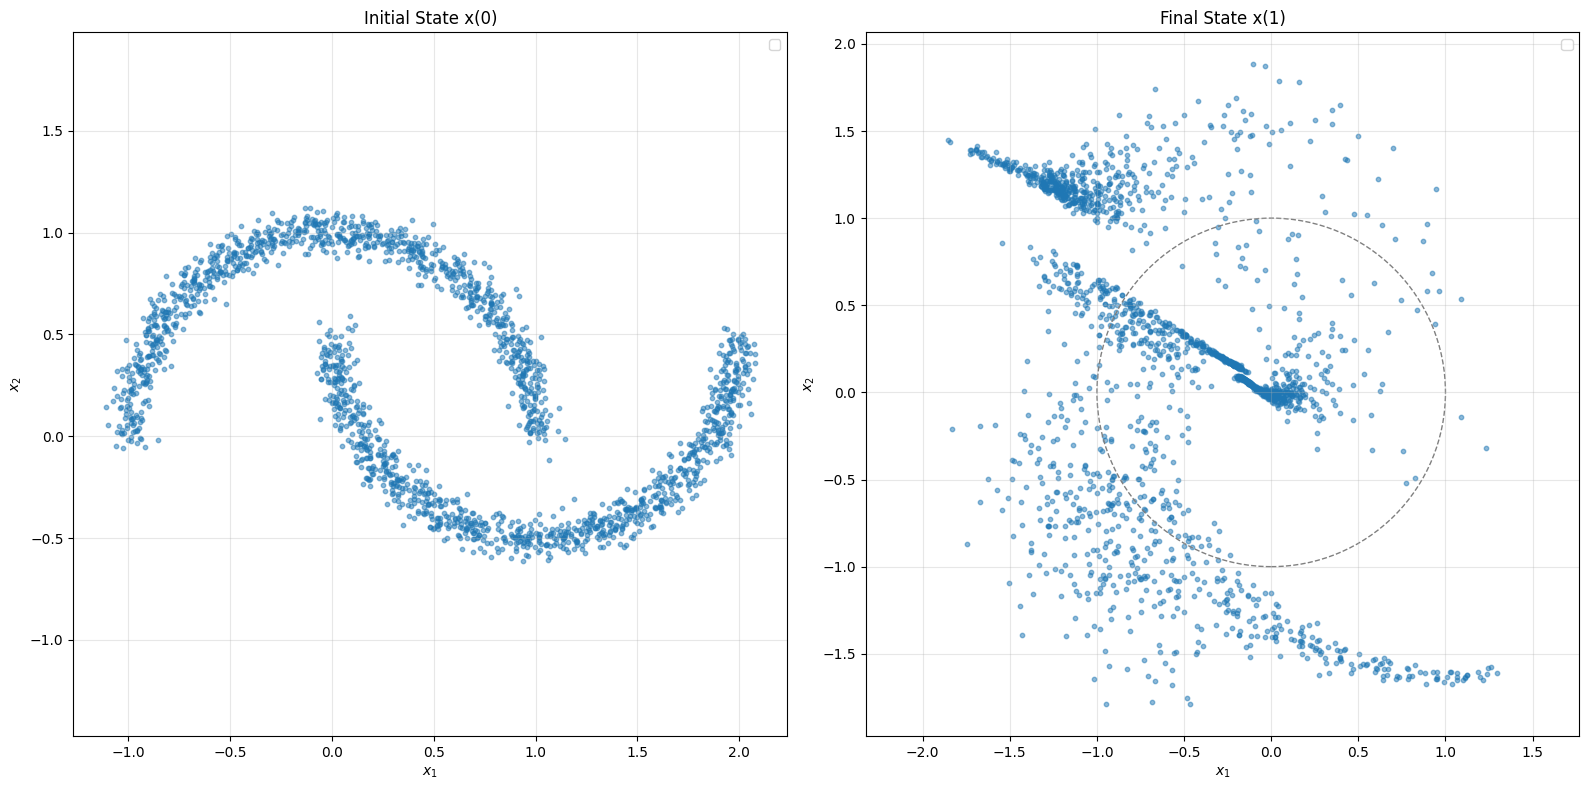

In [44]:
Synthetic2DViz.plot_trajectories(
    model,
    dataset,
    n_samples=2000,
    n_steps=100,
    save_path=os.path.join(
        FIGURES_DIR,
        f'01_{DATASET_NAME}_{MODEL_NAME}_trajectories.png'
    )
)
plt.tight_layout()
plt.show()


## 4. Visualizar Vector Field


Figure saved to: ../results/figures/01_moons_neuralode_vector_fields.png
Figure saved to: ../results/figures/01_moons_neuralode_vector_fields.png
Figure saved to: ../results/figures/01_moons_neuralode_vector_fields.png


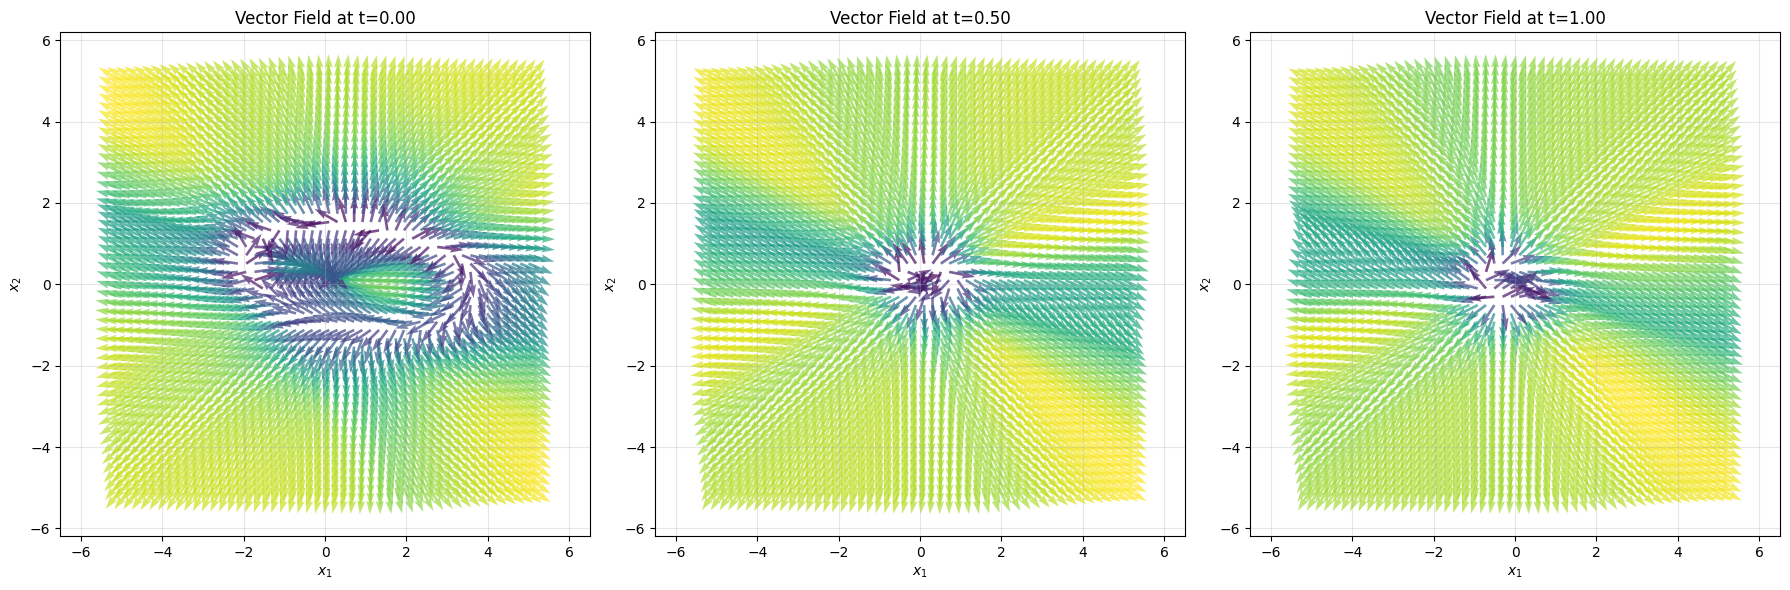

In [45]:
# Plotar vector field em diferentes tempos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, t in enumerate([0.0, 0.5, 1.0]):
    Synthetic2DViz.plot_vector_field(
        model,
        xlim=(-5, 5),
        ylim=(-5, 5),
        n_grid=50,
        t=t,
        ax=axes[i],
        save_path=os.path.join(
            FIGURES_DIR,
            f'01_{DATASET_NAME}_{MODEL_NAME}_vector_fields.png'
        )
    )
plt.tight_layout()
plt.show()

## 5. Visualizar Transformação


Figure saved to: ../results/figures/01_moons_neuralode_transformation.png


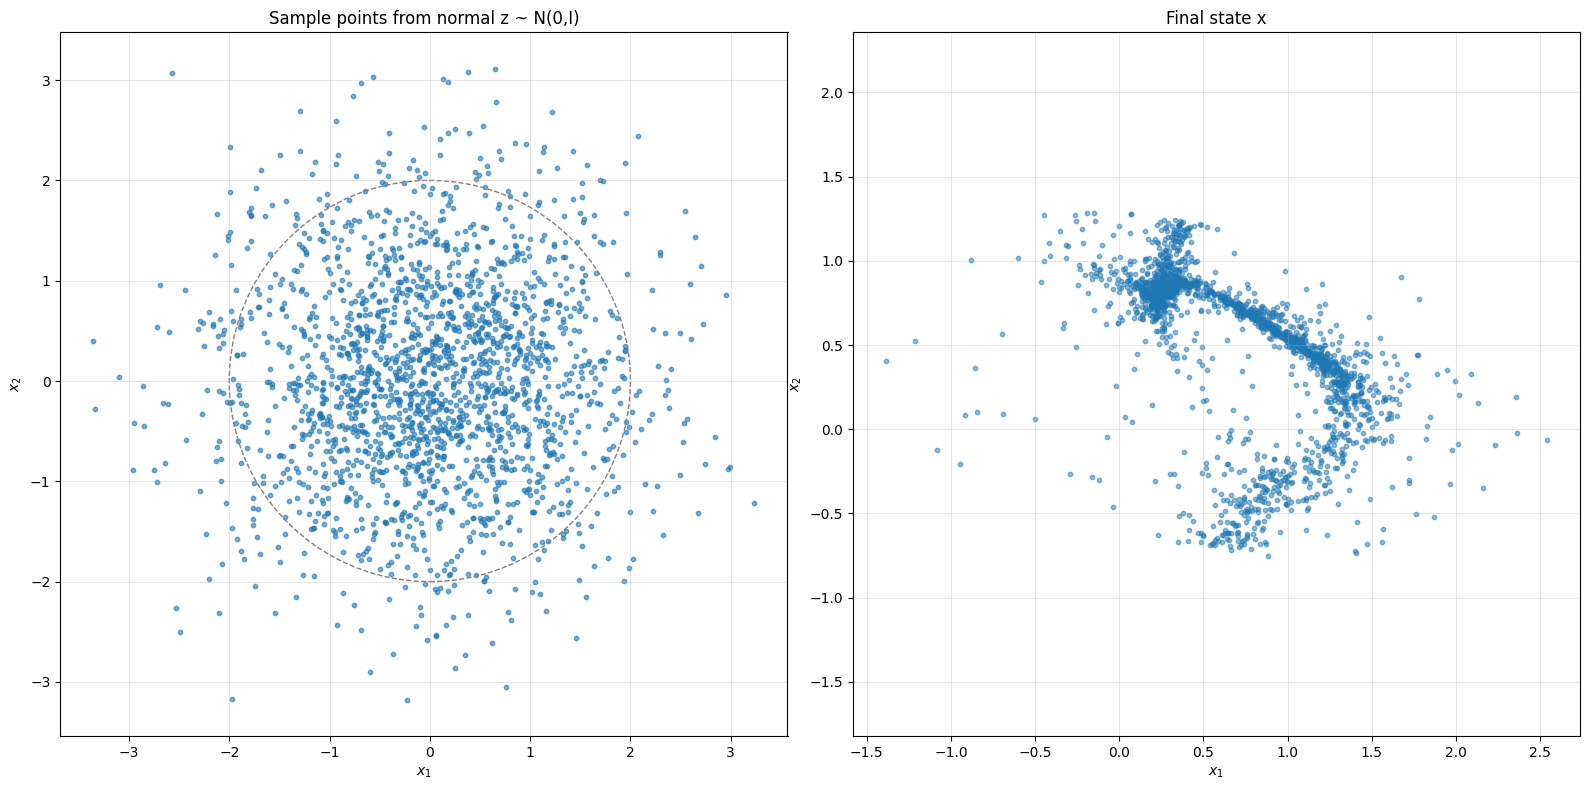

In [46]:
Synthetic2DViz.plot_transformation(
    model,
    n_samples=2000,
    n_steps=100,
    save_path=os.path.join(
        FIGURES_DIR,
        f'01_{DATASET_NAME}_{MODEL_NAME}_transformation.png'
    )
)
plt.tight_layout()
plt.show()


## 6. Analisar NFEs (Number of Function Evaluations)


In [ ]:
# Comparar diferentes solvers
solvers = ['euler', 'rk4', 'dopri5']
nfe_results = {}

# Usar amostras de N(0, I) para contagem de NFEs
sample_batch = torch.randn(10, 2).to(device)

print("=== Comparação de Solvers ===")
for solver in solvers:
    vf_test = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
    model_test = NeuralODE(
        vf_test,
        solver=solver,
        rtol=1e-3,
        atol=1e-4,
    ).to(device)
    model_test.vf.load_state_dict(model.vf.state_dict())
    nfe = count_nfe(model_test, sample_batch)
    nfe_results[solver] = nfe
    print(f"{solver}: {nfe} NFEs")

# Comparar diferentes tolerâncias
tolerances = [(1e-2, 1e-3), (1e-3, 1e-4), (1e-4, 1e-5)]
nfe_tol_results = {}

print("\n=== Comparação de Tolerâncias (dopri5) ===")
for rtol, atol in tolerances:
    vf_test = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
    model_test = NeuralODE(
        vf_test,
        solver='dopri5',
        rtol=rtol,
        atol=atol,
    ).to(device)
    model_test.vf.load_state_dict(model.vf.state_dict())
    nfe = count_nfe(model_test, sample_batch)
    nfe_tol_results[(rtol, atol)] = nfe
    print(f"rtol={rtol}, atol={atol}: {nfe} NFEs")
